In [1]:
module O

using Distributions
using Random

struct NormalGamma <: ContinuousUnivariateDistribution
    μ
    λ
    a
    b
end

function Base.rand(rng::AbstractRNG, d::NormalGamma)
    (; μ, λ, a, b) = d
    rand(rng, Normal(μ, inv(sqrt(λ * rand(Gamma(a, b))))))
end

end

Main.O

In [2]:
tmp = Vector{Float64}(undef, 10^6)
@time O.rand!(O.NormalGamma(1, 2, 2.1, 0.5), tmp)
@time O.rand!(O.NormalGamma(1, 2, 2.1, 0.5), tmp)
@time O.rand!(O.NormalGamma(1, 2, 2.1, 0.5), tmp);

  0.713671 seconds (8.77 M allocations: 194.933 MiB, 15.64% gc time, 31.25% compilation time)
  0.401586 seconds (8.00 M allocations: 152.580 MiB, 2.92% gc time)
  0.413190 seconds (8.00 M allocations: 152.580 MiB, 3.15% gc time)


In [3]:
@code_warntype rand(O.Random.default_rng(), O.NormalGamma(1, 2, 3, 4))

MethodInstance for rand(::Random.TaskLocalRNG, ::Main.O.NormalGamma)
  from rand(rng::Random.AbstractRNG, d::Main.O.NormalGamma) in Main.O at In[1]:13
Arguments
  #self#::Core.Const(rand)
  rng::Core.Const(Random.TaskLocalRNG())
  d::Main.O.NormalGamma
Locals
  b::Any
  a::Any
  λ::Any
  μ::Any
Body::Any
1 ─       (μ = Base.getproperty(d, :μ))
│         (λ = Base.getproperty(d, :λ))
│         (a = Base.getproperty(d, :a))
│         (b = Base.getproperty(d, :b))
│   %5  = μ::Any
│   %6  = λ::Any
│   %7  = Main.O.Gamma(a, b)::Distributions.Gamma
│   %8  = Main.O.rand(%7)::Any
│   %9  = (%6 * %8)::Any
│   %10 = Main.O.sqrt(%9)::Any
│   %11 = Main.O.inv(%10)::Any
│   %12 = Main.O.Normal(%5, %11)::Distributions.Normal
│   %13 = Main.O.rand(rng, %12)::Any
└──       return %13



In [4]:
module Q

using Distributions
using Random

struct NormalGamma{Tμ, Tλ, Ta, Tb} <: ContinuousUnivariateDistribution
    μ::Tμ
    λ::Tλ
    a::Ta
    b::Tb
end

function Base.rand(rng::AbstractRNG, d::NormalGamma)
    (; μ, λ, a, b) = d
    rand(rng, Normal(μ, inv(sqrt(λ * rand(Gamma(a, b))))))
end

end

Main.Q

In [5]:
using Random
using Distributions
using StatsPlots
default(fmt = :png)

res(xlim, A) = A[first(xlim) .< A .< last(xlim)]

μ, λ, a, b = 1, 2, 1.5, 4
ng_org = O.NormalGamma(μ, λ, a, b)
ng_rev = Q.NormalGamma(μ, λ, a, b)
normal = Normal(μ, 1/√(λ*a*b))
tdist = μ + TDist(2a)/√(λ*a*b)

A = Vector{Float64}(undef, 10^6)
B = similar(A)
C = similar(A)
A = @time rand!(ng_org, A)
A = @time rand!(ng_org, A)
A = @time rand!(ng_org, A)
B = @time rand!(ng_rev, B)
B = @time rand!(ng_rev, B)
B = @time rand!(ng_rev, B)
C = @time rand!(tdist, C)
C = @time rand!(tdist, C)
C = @time rand!(tdist, C)
;

  0.404534 seconds (8.02 M allocations: 153.928 MiB, 7.86% gc time, 2.03% compilation time)
  0.381746 seconds (8.00 M allocations: 152.580 MiB, 4.92% gc time)
  0.378809 seconds (8.00 M allocations: 152.580 MiB, 3.18% gc time)
  0.074955 seconds (37.05 k allocations: 2.076 MiB, 21.77% compilation time)
  0.059850 seconds
  0.059976 seconds
  0.091595 seconds (128.33 k allocations: 6.742 MiB, 8.84% gc time, 36.64% compilation time)
  0.058394 seconds
  0.057663 seconds


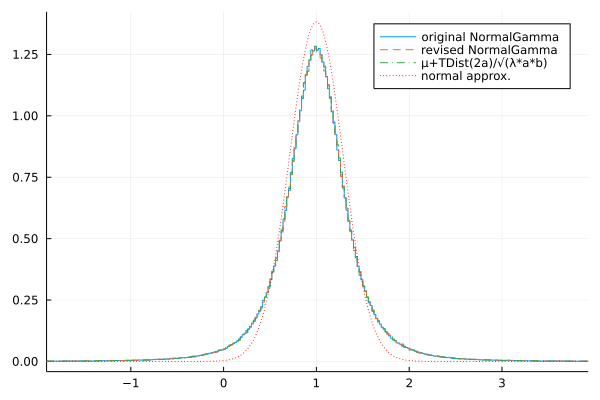

In [6]:
xlim = quantile.(Ref(A), (0.001, 0.999))
bin = round(Int, abs(-(xlim...))*50)
stephist(res(xlim, A); norm=true, label="original NormalGamma", bin)
stephist!(res(xlim, B); norm=true, label="revised NormalGamma", bin, ls=:dash)
stephist!(res(xlim, C); norm=true, label="μ+TDist(2a)/√(λ*a*b)", bin, ls=:dashdot)
plot!(normal, xlim...; label="normal approx.", c=:red, ls=:dot)
plot!(; xlim)